In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from notebooks.backtesting_utils import get_sma

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="AAPL"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_sma = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')
df_sma = get_sma(df_sma)

In [4]:
df_sma.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,sma_short,sma_long,position,returns,strategy
date_reference,,,,,,,,,,,
2025-10-20,AAPL,262.24,264.375,255.6300,255.885,90483029,252.060,253.8010,-1,0.038681,-0.038681
2025-10-21,AAPL,262.77,265.290,261.8300,261.880,46695948,252.689,254.2180,-1,0.002019,-0.002019
2025-10-22,AAPL,258.45,262.850,255.4300,262.650,45015254,252.728,254.5250,-1,-0.016577,0.016577
2025-10-23,AAPL,259.58,260.620,258.0101,259.940,32754941,253.282,254.6605,-1,0.004363,-0.004363
2025-10-24,AAPL,262.82,264.130,259.1800,261.190,38253717,255.037,255.0285,1,0.012404,-0.012404


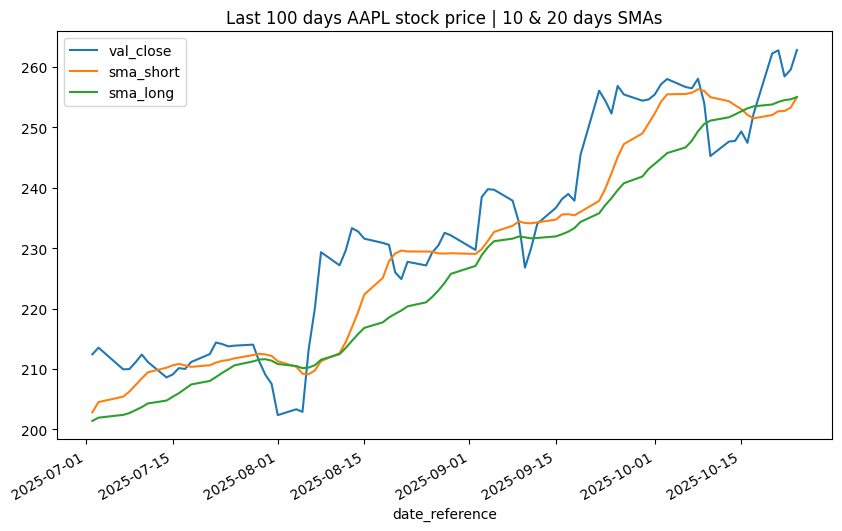

In [5]:
df_sma[["val_close", "sma_short", "sma_long"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days SMAs", figsize=(10, 6));

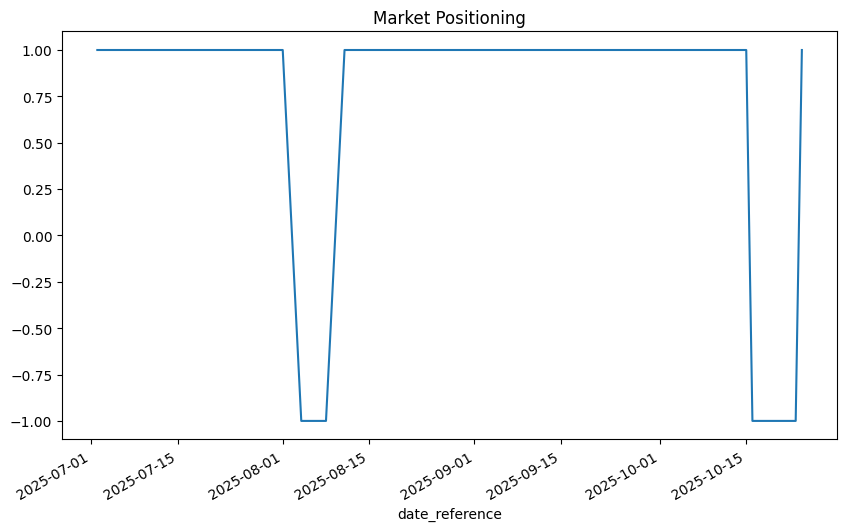

In [6]:
df_sma['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_sma[['returns', 'strategy']].sum().apply(np.exp)

returns     1.264652
strategy    0.859566
dtype: float64

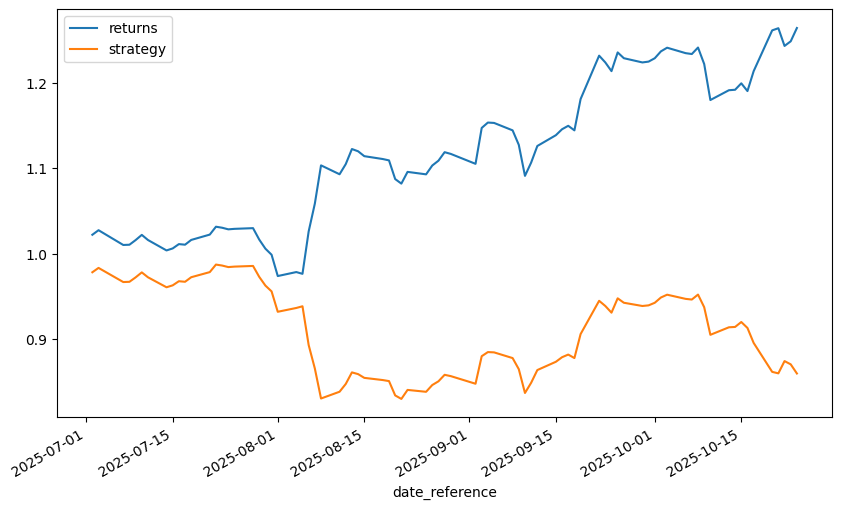

In [8]:
df_sma[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_sma['prev_position'] = df_sma['position'].shift(1)
crossovers = df_sma[df_sma['position'] != df_sma['prev_position']]
print(crossovers[['val_close', 'sma_short', 'sma_long', 'position']])

                val_close  sma_short  sma_long  position
date_reference                                          
2025-07-02         212.44    202.845  201.4215         1
2025-08-04         203.35    210.386  210.5075        -1
2025-08-11         227.18    212.635  212.4770         1
2025-10-16         247.45    252.078  253.1535        -1
2025-10-24         262.82    255.037  255.0285         1
